<a href="https://colab.research.google.com/github/sjino/Lecture/blob/master/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EA%B0%9C%EB%A1%A0/image_classification(pytorch_tutorial).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Prepare the Dataset**

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#CIFAR에 대해서만 pytorch가 제공하는 데이터 셋, 일반적으로는 직접 데이터셋을 만들어야한다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**Define the func to show the image**

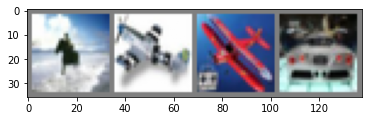

horse plane plane   car


In [17]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Define the convolutional neural network**

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # convolutional network
        self.pool = nn.MaxPool2d(2, 2) # Maxpooling
        self.conv2 = nn.Conv2d(6, 16, 5) # convolutional network
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # fully-connected network
        self.fc2 = nn.Linear(120, 84) # fully-connected network
        self.fc3 = nn.Linear(84, 10) # fully-connected network

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # ↙출력값(Conv->ReLU->Pooling) 아래로 넘겨주기
        x = self.pool(F.relu(self.conv2(x))) # ↙출력값(Conv->ReLU->Pooling) 아래로 넘겨주기
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

**Define loss function and optimizer**

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Train the network**

In [20]:
for epoch in range(2):  # loop over the dataset multiple times #하나의 epoch 위한 for문

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #batch size 위한 for문
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data # 이미지 , Ground Truth = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) #output: score
        loss = criterion(outputs, labels) #cross entropy loss
        loss.backward() #backpropagation
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.191
[1,  4000] loss: 1.841
[1,  6000] loss: 1.680
[1,  8000] loss: 1.574
[1, 10000] loss: 1.536
[1, 12000] loss: 1.489
[2,  2000] loss: 1.399
[2,  4000] loss: 1.377
[2,  6000] loss: 1.364
[2,  8000] loss: 1.330
[2, 10000] loss: 1.322
[2, 12000] loss: 1.307
Finished Training


**학습결과 저장**

In [21]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

**Test the network**

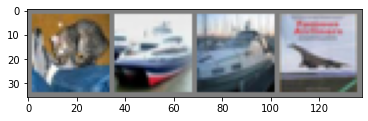

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH)) #load trained model

outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 55 %
Accuracy of  bird : 27 %
Accuracy of   cat : 38 %
Accuracy of  deer : 52 %
Accuracy of   dog : 47 %
Accuracy of  frog : 49 %
Accuracy of horse : 63 %
Accuracy of  ship : 77 %
Accuracy of truck : 66 %
